## Reference: https://tel.archives-ouvertes.fr/tel-00422569v2/document p.115

In [1]:
using Revise, LazySets, Plots#, ReachabilityAnalysis

┌ Info: Precompiling LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1260


In [9]:
using LazySets: center, _above, normalize
function BOUND_INTERSECT_2D(Z::AbstractZonotope, L::Line2D) # 8.2
    c = center(Z)
    P = copy(c)
    G = genmat(Z)
    r = ngens(Z)
    for i = 1:r
        gi = view(G, :, i)
        if(gi[2] > 0 || (gi[2] == 0 && gi[1] > 0))
            gi .= -gi
        end
        P = P - gi
    end
    G = sortslices(G, dims=2, by=x->atan(x[2], x[1])) # sort gens
    if P[1] > L.b
        G .= G[:,end:-1:1]
    end
    j = 1
    while isempty(intersection(Line2D(P, P.+G[:, j]), L))
        P = P + G[:, j]
        j += 1
    end
    vec = intersection(Line2D(P, P.+G[:, j]), L)
    return vec
end

BOUND_INTERSECT_2D (generic function with 1 method)

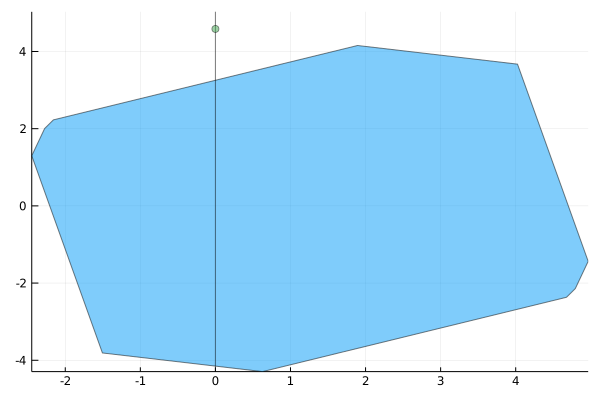

In [10]:
Z = rand(Zonotope, num_generators=5)
L = Line2D([0, 0.], [0, 1.])
i = BOUND_INTERSECT_2D(Z, L)
plot(Z)
plot!(L)
plot!(i)

In [4]:
function intersec(Z::AbstractZonotope{N}, L::Line2D) where {N} # 8.3
    c = center(Z)
    P = copy(c)
    gens = genmat(Z)
    r = ngens(Z)
    for gi in [gens[:, x] for x in 1:r]
        if(gi[2] > 0 || (gi[2] == 0 && gi[1] > 0))
            gi = -gi
        end
        P = P - gi
    end
    G = Vector{Vector{N}}(undef, 0)
    if(P[1] < L.b)
        for gi in [gens[:, x] for x in 1:r]
            if(gi[1] >= 0)
                push!(G, gi)
            end
        end
    else
        for gi in [gens[:, x] for x in 1:r]
            if(gi[1] <= 0)
                push!(G, gi)
            end
        end
    end
    s = sum(G)
    
    while length(G) > 1
        G1 = Vector{Vector{N}}(undef, 0)
        G2 = copy(G1)
        for gi in G
            if _above(gi, s, [0, 1])
                push!(G1, gi)
            else
                push!(G2, gi)
            end
        end
        s1 = 2 * sum(G1)
        if !isempty(intersection(Line2D(P, P.+s1), L))
            G = G1
            s = s1
        else
            G = G2
            s = s - s1
            P = P + s1
        end
        break
    end
    vec = intersection(Line2D(P, P.+s), L)
end

intersec (generic function with 1 method)

In [5]:
i2 = intersec(Z, L)

Singleton{Float64,Array{Float64,1}}([-0.0, 6.321168731156943])

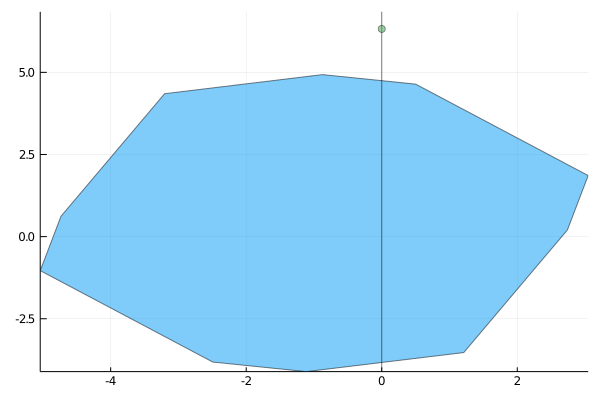

In [6]:
plot(Z)
plot!(L)
plot!(i2)

In [ ]:
using ModelingToolkit

In [ ]:
Z = rand(Zonotope)

In [ ]:
ρ([0, 1.], Z)

In [ ]:
σ([0, 1.], Z)

In [ ]:
vars = @variables x y

In [ ]:
H = HalfSpace(x >= y, vars)

In [ ]:
plot(Z, ratio=1)
plot!(H)
plot!(LineSegment([0, 0.], -H.a))

In [ ]:
dirs = collect(BoxDirections(2))

In [ ]:
function inter(Z::Zonotope{N}, H::HalfSpace{N}) where {N}
    n = dim(Z)
    if ρ(-H.a, Z) < H.b
        return false
    end
    gens = Vector{Vector{N}}(undef, 2n)#Matrix{N}(undef, n, 2n)
    dirs = [H.a, -H.a, [-1 0; 0 1.] * H.a, [1 0; 0 -1.] * -H.a]
    for i=1:2n
        gens[i] = σ(dirs[i], Z)
    end
    return gens
end

In [ ]:
inter(Z, H)

In [ ]:
plot(Z, ratio=1)
plot!(H)
plot!(LineSegment([0, 0.], -H.a))
plot!([Singleton(inter(Z, H)[i]) for i in 1:4])

In [ ]:
Z = rand(Zonotope)

In [ ]:
constraints_list(Z)

In [ ]:
function inters(Z, H)
    constraints = constraints_list(Z)
    push!(constraints, H)
    return overapproximate(HPolyhedron(constraints), Zonotope, BoxDirections(dim(Z)))
end

function inters_v2(Z, H)
    n = dim(Z)
    for i = 1:n
        high = max(intersection())
    end
    return 
end

In [ ]:
plot(Z, ratio=1)
plot!(H)
plot!(inters(Z, H), label="intersection")

In [ ]:
using BenchmarkTools
@btime constraints_list(Z)
@btime inters($Z, $H)

In [ ]:
using LazySets: set
function _overapproximate(P::Poly, ::Type{<:Zonotope}) where {Poly<:AbstractPolytope}
    n = dim(P)
    j = 1
    p = Vector{Poly}(undef, Int(floor(n/2)))
    for i=1:2:n-1
        p[j] = set(Projection(P, [i, i+1]))
        j += 1
    end
    dirs = OctDirections(n)
    if !iseven(n)
        push!(p, set(Projection(P, [n])))
    end
    Z = [overapproximate(poly, Zonotope, dirs) for poly in p]
    Z = reduce(×, Z)
    return Z
end

In [ ]:
P = rand(VPolytope, dim=10);

In [ ]:
Z = _overapproximate(P, Zonotope);

In [ ]:
plot(Projection(P, vars=(1, 2)))
plot!(Projection(_overapproximate(P, Zonotope), vars=(1, 2)))

In [ ]:
using BenchmarkTools

In [ ]:
@btime _overapproximate($P, Zonotope);

In [ ]:
@btime overapproximate($P, Zonotope, $OctDirections(10));